## Importation

In [53]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('ENB2012_data.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [3]:
columns_names = {
    'X1' : 'Relative_Compactness',
    'X2' : 'Surface_Area',
    'X3' : 'Wall_Area',
    'X4' : 'Roof_Area',
    'X5' : 'Overall_Height',
    'X6' : 'Orientation',
    'X7' : 'Glazing_Area',
    'X8' : 'Glazing_Area_Distribution',
    'Y1' : 'Heating_Load',
    'Y2' : 'Cooling_Load'
}

df = df.rename(columns = columns_names)
df.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


There are not any missing values and the variables are well typed

## Correlation matrix

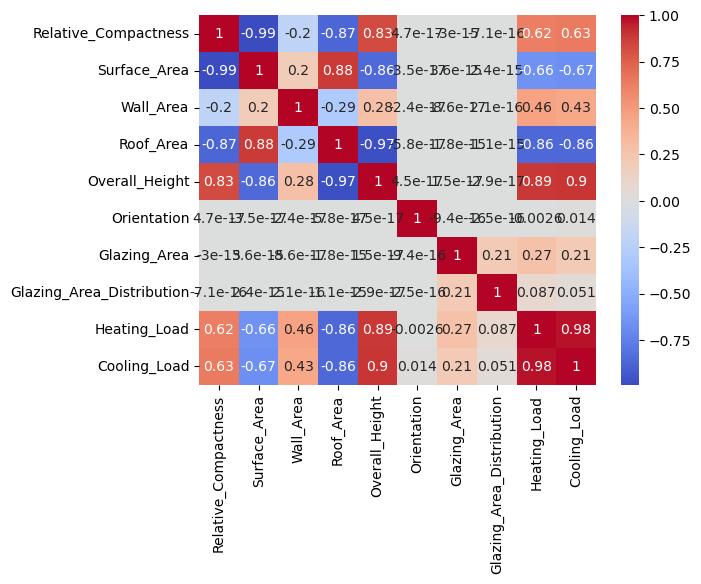

In [24]:
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm');

target = heating_load & cooling_load

correlated features =
    - overhall_height (Pearson's coefficient of 0.89 & 0.9)
    - relative_compactness (less correlated)

## Classification

In [25]:
df['Total'] = df['Heating_Load'] + df['Cooling_Load']

target = pd.qcut(df['Total'], q = [0, .25, .5, .75, 1.], labels = [0,1,2,3])

feats = df.drop(['Total','Heating_Load', 'Cooling_Load'], axis = 1)

In [26]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size = 0.2, random_state = 2)

# Features normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Target normalization
encoder = LabelEncoder()
y_train_scaled = encoder.fit_transform(y_train)
y_test_scaled = encoder.transform(y_test)

### KNN

In [30]:
# Modelisation with KNN
clf_knn = KNeighborsClassifier()
param_knn = {'n_neighbors' : np.arange(2,51)}

# GridSearchCV
grid_knn = GridSearchCV(clf_knn, param_grid = param_knn , cv=3)

# Training
grid_knn.fit(X_train_scaled, y_train_scaled)

# Bests parameters
print('Bests parameters : ', grid_knn.best_params_)

Bests parameters :  {'n_neighbors': 3}


In [31]:
# KNN with bests parameters
knn_final = KNeighborsClassifier(n_neighbors=3)
    
# Training
knn_final.fit(X_train_scaled, y_train_scaled)

# Prediction
y_pred_knn = knn_final.predict(X_test_scaled)
    
# Confusion matrix & Classification report    
print(pd.crosstab(y_test_scaled, y_pred_knn, rownames=['real class'], colnames=['predicted class']))
print('\n')
print(classification_report(y_test_scaled, y_pred_knn))
print('Test score : ', knn_final.score(X_test_scaled, y_test_scaled))

predicted class   0   1   2   3
real class                     
0                29   4   0   0
1                 3  34   1   0
2                 0   1  40   4
3                 0   0   5  33


              precision    recall  f1-score   support

           0       0.91      0.88      0.89        33
           1       0.87      0.89      0.88        38
           2       0.87      0.89      0.88        45
           3       0.89      0.87      0.88        38

    accuracy                           0.88       154
   macro avg       0.88      0.88      0.88       154
weighted avg       0.88      0.88      0.88       154

Test score :  0.8831168831168831


### SVM

In [32]:
# Modelisation with SVC
clf_svc = SVC(random_state = 2)
param_svc = {'kernel' : ['rbf','linear'], 
             'C' : [0.1,1,10,50]}

# GridSearchCV
grid_svc = GridSearchCV(clf_svc, param_grid = param_svc , cv=3)

# Training
grid_svc.fit(X_train_scaled, y_train_scaled)

# Bests parameters
print('Bests parameters : ', grid_svc.best_params_)

Bests parameters :  {'C': 50, 'kernel': 'rbf'}


In [33]:
# SVC with bests parameters
svc_final = SVC(C = 50, kernel = 'rbf', random_state = 2)
    
# Training
svc_final.fit(X_train_scaled, y_train_scaled)

# Prediction
y_pred_svc = svc_final.predict(X_test_scaled)
    
# Confusion matrix & Classification report        
print(pd.crosstab(y_test_scaled, y_pred_svc, rownames=['real class'], colnames=['predicted class']))
print('\n')
print(classification_report(y_test_scaled, y_pred_svc))
print('Test score : ', svc_final.score(X_test_scaled, y_test_scaled))

predicted class   0   1   2   3
real class                     
0                30   3   0   0
1                 1  35   2   0
2                 0   1  41   3
3                 0   0   5  33


              precision    recall  f1-score   support

           0       0.97      0.91      0.94        33
           1       0.90      0.92      0.91        38
           2       0.85      0.91      0.88        45
           3       0.92      0.87      0.89        38

    accuracy                           0.90       154
   macro avg       0.91      0.90      0.91       154
weighted avg       0.90      0.90      0.90       154

Test score :  0.9025974025974026


### Random Forest

In [34]:
#Modelisation with RandomForest
clf_rf = RandomForestClassifier(random_state = 2)

pair = []
for i in np.arange(2,31):
    if i%2 == 0:
        pair.append(i)
        
param_rf = {'max_features' : ['sqrt','log2',None], 
            'min_samples_split' : pair}

# GridSearchCV
grid_rf = GridSearchCV(clf_rf, param_grid = param_rf , cv=3) # cv=3 

# Training
grid_rf.fit(X_train_scaled, y_train_scaled)

# Bests parameters
print('Bests parameters : ', grid_rf.best_params_)

Bests parameters :  {'max_features': None, 'min_samples_split': 6}


In [35]:
# Modelisation with bests parameters
rf_final = RandomForestClassifier(random_state = 2, max_features=None, min_samples_split=6)
    
# Training
rf_final.fit(X_train_scaled, y_train_scaled)

# Prediction
y_pred_rf = svc_final.predict(X_test_scaled)
    
# Confusion matrix & Classification report            
print(pd.crosstab(y_test_scaled, y_pred_rf, rownames=['real class'], colnames=['predicted class']))
print('\n')
print(classification_report(y_test_scaled, y_pred_rf))
print('Test score : ', rf_final.score(X_test_scaled, y_test_scaled))

predicted class   0   1   2   3
real class                     
0                30   3   0   0
1                 1  35   2   0
2                 0   1  41   3
3                 0   0   5  33


              precision    recall  f1-score   support

           0       0.97      0.91      0.94        33
           1       0.90      0.92      0.91        38
           2       0.85      0.91      0.88        45
           3       0.92      0.87      0.89        38

    accuracy                           0.90       154
   macro avg       0.91      0.90      0.91       154
weighted avg       0.90      0.90      0.90       154

Test score :  0.9545454545454546


## Regression

In [4]:
feats = df.drop(['Heating_Load', 'Cooling_Load'], axis = 1)
targets = df[['Heating_Load', 'Cooling_Load']]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(feats, targets, test_size = 0.2, random_state =2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_scaled)

y_pred_lr = lr.predict(X_test_scaled)
y_pred_lr_train = lr.predict(X_train_scaled)

# training set
mae_lr_train = mean_absolute_error(y_train_scaled,y_pred_lr_train)
mse_lr_train = mean_squared_error(y_train_scaled,y_pred_lr_train,squared=True)
rmse_lr_train = mean_squared_error(y_train_scaled,y_pred_lr_train,squared=False)
r2_train = lr.score(X_train_scaled, y_train_scaled)

# test set
mae_lr_test = mean_absolute_error(y_test_scaled,y_pred_lr)
mse_lr_test = mean_squared_error(y_test_scaled,y_pred_lr,squared=True)
rmse_lr_test = mean_squared_error(y_test_scaled,y_pred_lr,squared=False)
r2_test = lr.score(X_test_scaled, y_test_scaled)

train_set = [mae_lr_train,mse_lr_train,rmse_lr_train,r2_train]
test_set = [mae_lr_test,mse_lr_test,rmse_lr_test,r2_test]

scores = pd.DataFrame({"train_set": train_set, "test_set": test_set}, index=['MAE','MSE','RMSE','R2'])

In [12]:
scores

,train_set,test_set
MAE,0.214157,0.245129
MSE,0.092647,0.114299
RMSE,0.303624,0.336666
R2,0.907353,0.877388


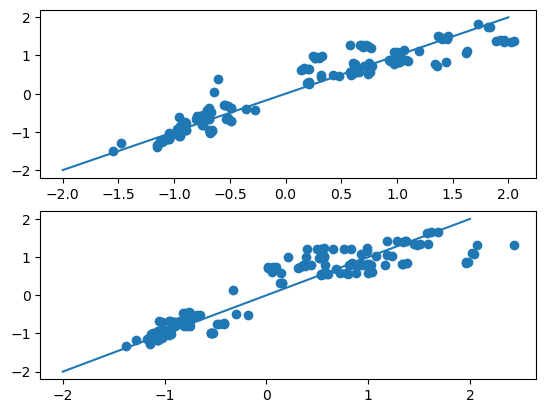

In [13]:
heating, cooling = [], []

for element in y_test_scaled :
    heating.append(element[0])
    cooling.append(element[1])

heating_pred, cooling_pred = [], []

for element in y_pred_lr :
    heating_pred.append(element[0])
    cooling_pred.append(element[1])

plt.subplot(211)
plt.scatter(heating, heating_pred)
plt.plot([-2,2],[-2,2]);

plt.subplot(212)
plt.scatter(cooling, cooling_pred)
plt.plot([-2,2],[-2,2]);

In [42]:
y_pred_inverse = target_scaler.inverse_transform(y_pred_lr)

heating_inverse = [i[0] for i in y_pred_inverse]
cooling_inverse = [i[1] for i in y_pred_inverse]


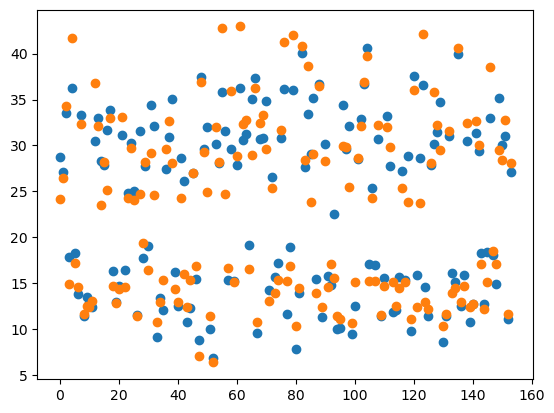

In [41]:
plt.scatter(range(len(heating_inverse)), heating_inverse)
plt.scatter(range(len(y_test['Heating_Load'])), y_test['Heating_Load']);

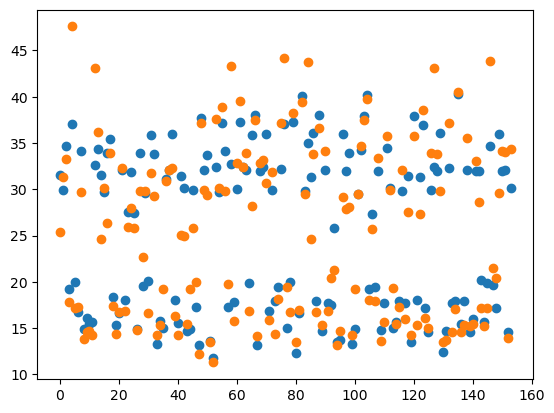

In [43]:
plt.scatter(range(len(cooling_inverse)), cooling_inverse)
plt.scatter(range(len(y_test['Cooling_Load'])), y_test['Cooling_Load']);

In [73]:
pair = []
for i in np.arange(2,31):
    if i%2 == 0:
        pair.append(i)

knn_params = {'n_neighbors':np.arange(1,51,1)}

rf_params = {'max_features' : ['sqrt','log2',None], 
             'min_samples_split' : pair,
             'max_depth':[5,10,15]}

xgb_params = {'n_estimators':[1,5,10],
              'learning_rate':[0.01,0.1],
              'max_depth':[3,5,10],
              'colsample_bytree':[0.2,0.4,0.6,0.8]}

models = [KNeighborsRegressor(), RandomForestRegressor(), XGBRegressor()]
params = [knn_params, rf_params, xgb_params]

best_params = []

for model,param in zip(models, params) :
    grid = GridSearchCV(model, param_grid = param , cv=3)
    grid.fit(X_train_scaled, y_train_scaled)
    best_params.append(grid.best_params_)

In [44]:
def regression_modelisation(model):

    model.fit(X_train_scaled, y_train_scaled)
    y_pred = model.predict(X_test_scaled)
    y_pred_train = model.predict(X_train_scaled)

    # training set
    mae_train = mean_absolute_error(y_train_scaled,y_pred_train)
    mse_train = mean_squared_error(y_train_scaled,y_pred_train,squared=True)
    rmse_train = mean_squared_error(y_train_scaled,y_pred_train,squared=False)
    r2_train = model.score(X_train_scaled, y_train_scaled)

    # test set
    mae_test = mean_absolute_error(y_test_scaled,y_pred)
    mse_test = mean_squared_error(y_test_scaled,y_pred,squared=True)
    rmse_test = mean_squared_error(y_test_scaled,y_pred,squared=False)
    r2_test = model.score(X_test_scaled, y_test_scaled)

    train_set = [mae_train,mse_train,rmse_train,r2_train]
    test_set = [mae_test,mse_test,rmse_test,r2_test]

    scores = pd.DataFrame({"train_set": train_set, "test_set": test_set}, index=['MAE','MSE','RMSE','R2'])

    return scores

In [68]:
best_params

[{'n_neighbors': 3},
 {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2},
 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 10}]

In [75]:
regression = [KNeighborsRegressor(n_neighbors=3), 
              RandomForestRegressor(max_depth=10, max_features='sqrt',min_samples_split=2),
              XGBRegressor(colsample_bytree = 0.8, n_estimators = 10, learning_rate=0.1, max_depth=10)]

results = []

for element in regression :
    results.append(regression_modelisation(element))

In [80]:
results_knn, results_rf, results_xg = results[0],results[1],results[2]

print("Results KNN :", '\n', results_knn)
print('\n', "Results RF :", '\n', results_rf)
print('\n',"Results XGB :", '\n', results_xg)
print('\n',"Results LR :", '\n', regression_modelisation(LinearRegression()))

Results KNN : 
       train_set  test_set
MAE    0.098866  0.168682
MSE    0.028819  0.060136
RMSE   0.168816  0.244603
R2     0.971181  0.935410

 Results RF : 
       train_set  test_set
MAE    0.037197  0.084358
MSE    0.003736  0.017941
RMSE   0.055663  0.121628
R2     0.996264  0.981103

 Results XGB : 
       train_set  test_set
MAE    0.365456  0.350447
MSE    0.177040  0.162088
RMSE   0.420695  0.402191
R2     0.822960  0.825624

 Results LR : 
       train_set  test_set
MAE    0.214157  0.245129
MSE    0.092647  0.114299
RMSE   0.303624  0.336666
R2     0.907353  0.877388
